In [2]:
import torch
import torch.nn as nn
from torchvision import datasets ,models,transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import sys
from torch.nn import Parameter

In [3]:
torch.__version__ 

'1.4.0'

In [4]:
torch.version.cuda

'10.1'

In [6]:
import syft as sy  # <-- NEW: import the Pysyft library
hook = sy.TorchHook(torch)  # <-- NEW: hook PyTorch ie add extra functionalities to support Federated Learning
bob = sy.VirtualWorker(hook, id="bob")  # <-- NEW: define remote worker bob
#alice = sy.VirtualWorker(hook, id="alice")  # <-- NEW: and alice

In [7]:
#Determine if there is a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [8]:
PATH_train="./train"
PATH_val="./val"
PATH_test="./test"

In [9]:
TRAIN =Path(PATH_train)
VALID = Path(PATH_val)
TEST=Path(PATH_test)
print(TRAIN)
print(VALID)
print(TEST)

train
val
test


In [10]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32
# learning rate
LR = 0.001

In [11]:
# convert data to a normalized torch.FloatTensor
train_transforms = transforms.Compose([transforms.Resize((50,50)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize((50,50)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize((50,50)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


In [12]:
# choose the training and test datasets
train_data = datasets.ImageFolder(TRAIN, transform=train_transforms)
valid_data = datasets.ImageFolder(VALID,transform=valid_transforms)
test_data = datasets.ImageFolder(TEST, transform=test_transforms)

In [13]:
print(train_data.class_to_idx)
print(valid_data.class_to_idx)

{'sick': 0, 'unsick': 1}
{'sick': 0, 'unsick': 1}


In [14]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers,shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,  num_workers=num_workers,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,  num_workers=num_workers)

In [15]:
images,labels=next(iter(train_loader))
images.shape,labels.shape

(torch.Size([32, 3, 50, 50]), torch.Size([32]))

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
classes = ['sick','unsick']
mean , std = torch.tensor([0.485, 0.456, 0.406]),torch.tensor([0.229, 0.224, 0.225])


def denormalize(image):
  image = transforms.Normalize(-mean/std,1/std)(image) #denormalize
  image = image.permute(1,2,0) #Changing from 3x224x224 to 224x224x3
  image = torch.clamp(image,0,1)
  return image

# helper function to un-normalize and display an image
def imshow(img):
    img = denormalize(img) 
    plt.imshow(img)

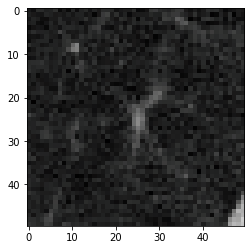

In [17]:
imshow(images[0])

In [18]:
#imshow(images[2])

/home/leo6532/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


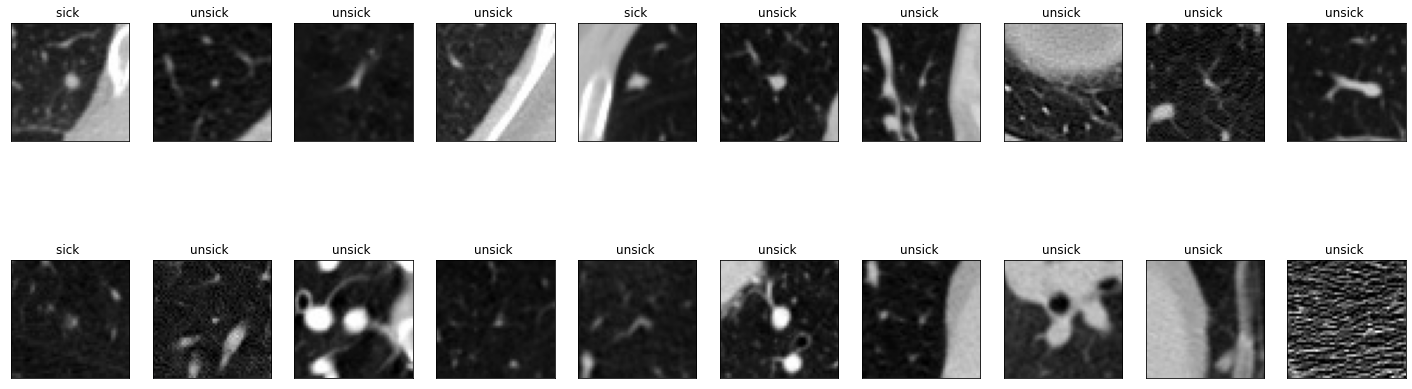

In [19]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
 # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 8))
#display 20 images
for idx in np.arange(20):
     ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
     imshow(images[idx])
     ax.set_title("{} ".format( classes[labels[idx]]))

In [20]:
# Create CNN Model
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=0) #output_shape=(16,220,220) 48
        #(224-5+1)/1 #(weigh-kernel+1)/stride 無條件進位
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) #output_shape=(16,110,110) #(220/2) 16 24 24
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0) #output_shape=(32,106,106) 20 20
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=1) #output_shape=(32,53,53) 10 10
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=1, stride=1, padding=0) #output_shape=(16,51,51) 10 10
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=1) #output_shape=(16,25,25) 5 5
        self.cnn4 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=1, stride=1, padding=0) #output_shape=(8,23,23) 5 5
        self.relu4 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=2) #output_shape=(8,11,11) 8 5 5
        # Fully connected 1 ,#input_shape=(8*12*12)
        self.fc1 = nn.Linear(8 * 11 * 11, 512) 
        #self.relu5 = nn.ReLU() # activation
        self.fc2 = nn.Linear(512, 2) 
        #self.output = nn.Softmax(dim=1)
        
    
    def forward(self, x):
        out = self.cnn1(x) # Convolution 1
        out = self.relu1(out)
        out = self.maxpool1(out)# Max pool 1
        out = self.cnn2(out) # Convolution 2
        out = self.relu2(out) 
        out = self.maxpool2(out) # Max pool 2
        out = self.cnn3(out) # Convolution 3
        out = self.relu3(out)
        out = self.maxpool3(out) # Max pool 3
        out = self.cnn4(out) # Convolution 4
        out = self.relu4(out)
        out = self.maxpool4(out) # Max pool 4
        out = out.view(out.size(0), -1) # last CNN faltten con. Linear NN
        out = self.fc1(out) # Linear function (readout)
        out = self.fc2(out)
        #out = self.output(out)

        return out

In [21]:
model = CNN_Model()
from torchsummary import summary
summary(model.cuda(), (3, 50, 50))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 48, 48]             448
              ReLU-2           [-1, 16, 48, 48]               0
         MaxPool2d-3           [-1, 16, 24, 24]               0
            Conv2d-4           [-1, 32, 22, 22]           4,640
              ReLU-5           [-1, 32, 22, 22]               0
         MaxPool2d-6           [-1, 32, 22, 22]               0
            Conv2d-7           [-1, 16, 22, 22]             528
              ReLU-8           [-1, 16, 22, 22]               0
         MaxPool2d-9           [-1, 16, 22, 22]               0
           Conv2d-10            [-1, 8, 22, 22]             136
             ReLU-11            [-1, 8, 22, 22]               0
        MaxPool2d-12            [-1, 8, 11, 11]               0
           Linear-13                  [-1, 512]         496,128
           Linear-14                   

In [22]:
#from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm

In [23]:
import torch.optim as optim    
optimizer = torch.optim.Adam(model.parameters(), lr=LR) 
criterion = nn.CrossEntropyLoss() 

running epoch: 1



	Training Loss: 0.404103 	Validation Loss: 0.411536
Validation loss decreased (inf --> 0.411536).  Saving model ...
running epoch: 2



	Training Loss: 0.338675 	Validation Loss: 0.347964
Validation loss decreased (0.411536 --> 0.347964).  Saving model ...
running epoch: 3



	Training Loss: 0.298553 	Validation Loss: 0.301773
Validation loss decreased (0.347964 --> 0.301773).  Saving model ...
running epoch: 4



	Training Loss: 0.274278 	Validation Loss: 0.298450
Validation loss decreased (0.301773 --> 0.298450).  Saving model ...
running epoch: 5



	Training Loss: 0.255180 	Validation Loss: 0.280279
Validation loss decreased (0.298450 --> 0.280279).  Saving model ...
running epoch: 6



	Training Loss: 0.233963 	Validation Loss: 0.267691
Validation loss decreased (0.280279 --> 0.267691).  Saving model ...
running epoch: 7



	Training Loss: 0.223746 	Validation Loss: 0.268835
running epoch: 8



	Training Loss: 0.217275 	Validation Loss: 0.296662
running epoch: 9



	Training Loss: 0.211480 	Validation Loss: 0.269180
running epoch: 10



	Training Loss: 0.190888 	Validation Loss: 0.261047
Validation loss decreased (0.267691 --> 0.261047).  Saving model ...
running epoch: 11



	Training Loss: 0.180047 	Validation Loss: 0.274304
running epoch: 12



	Training Loss: 0.169557 	Validation Loss: 0.307322
running epoch: 13



	Training Loss: 0.163607 	Validation Loss: 0.309686
running epoch: 14



	Training Loss: 0.158909 	Validation Loss: 0.306301
running epoch: 15



	Training Loss: 0.146262 	Validation Loss: 0.283939
running epoch: 16



	Training Loss: 0.136771 	Validation Loss: 0.302087
running epoch: 17



	Training Loss: 0.127703 	Validation Loss: 0.355536
running epoch: 18



	Training Loss: 0.128410 	Validation Loss: 0.367267
running epoch: 19



	Training Loss: 0.117120 	Validation Loss: 0.306303
running epoch: 20



	Training Loss: 0.110519 	Validation Loss: 0.338167
running epoch: 21



	Training Loss: 0.114815 	Validation Loss: 0.382223
running epoch: 22



	Training Loss: 0.101441 	Validation Loss: 0.365126
running epoch: 23



	Training Loss: 0.101956 	Validation Loss: 0.409721
running epoch: 24



	Training Loss: 0.088593 	Validation Loss: 0.481840
running epoch: 25



	Training Loss: 0.095750 	Validation Loss: 0.476299
running epoch: 26



	Training Loss: 0.083969 	Validation Loss: 0.402441
running epoch: 27



	Training Loss: 0.113063 	Validation Loss: 0.414286
running epoch: 28



	Training Loss: 0.084861 	Validation Loss: 0.424687
running epoch: 29



	Training Loss: 0.076014 	Validation Loss: 0.502492
running epoch: 30



	Training Loss: 0.065363 	Validation Loss: 0.489580
running epoch: 31



	Training Loss: 0.061528 	Validation Loss: 0.560421
running epoch: 32



	Training Loss: 0.049270 	Validation Loss: 0.537228
running epoch: 33



	Training Loss: 0.060260 	Validation Loss: 0.560726
running epoch: 34



	Training Loss: 0.053033 	Validation Loss: 0.564356
running epoch: 35



	Training Loss: 0.046448 	Validation Loss: 0.603441
running epoch: 36



	Training Loss: 0.047681 	Validation Loss: 0.570301
running epoch: 37



	Training Loss: 0.055043 	Validation Loss: 0.585778
running epoch: 38



	Training Loss: 0.040980 	Validation Loss: 0.687492
running epoch: 39



	Training Loss: 0.065690 	Validation Loss: 0.635193
running epoch: 40



	Training Loss: 0.035366 	Validation Loss: 0.719420
running epoch: 41



	Training Loss: 0.028414 	Validation Loss: 0.801882
running epoch: 42



	Training Loss: 0.061476 	Validation Loss: 0.668959
running epoch: 43



	Training Loss: 0.027229 	Validation Loss: 0.791289
running epoch: 44



	Training Loss: 0.028041 	Validation Loss: 0.903887
running epoch: 45



	Training Loss: 0.039375 	Validation Loss: 0.740335
running epoch: 46



	Training Loss: 0.039470 	Validation Loss: 0.798169
running epoch: 47



	Training Loss: 0.020089 	Validation Loss: 0.910274
running epoch: 48



	Training Loss: 0.045119 	Validation Loss: 0.650387
running epoch: 49



	Training Loss: 0.027861 	Validation Loss: 0.824585
running epoch: 50



	Training Loss: 0.031780 	Validation Loss: 0.688634
running epoch: 51



	Training Loss: 0.027143 	Validation Loss: 0.893106
running epoch: 52



	Training Loss: 0.032501 	Validation Loss: 0.776974
running epoch: 53



	Training Loss: 0.027781 	Validation Loss: 0.817629
running epoch: 54



	Training Loss: 0.025622 	Validation Loss: 0.792984
running epoch: 55



	Training Loss: 0.025957 	Validation Loss: 0.930946
running epoch: 56



	Training Loss: 0.130808 	Validation Loss: 0.507232
running epoch: 57



	Training Loss: 0.023898 	Validation Loss: 0.738020
running epoch: 58



	Training Loss: 0.017964 	Validation Loss: 0.929540
running epoch: 59



	Training Loss: 0.025224 	Validation Loss: 0.871775
running epoch: 60



	Training Loss: 0.032856 	Validation Loss: 0.867484
running epoch: 61



	Training Loss: 0.013911 	Validation Loss: 1.056545
running epoch: 62



	Training Loss: 0.027818 	Validation Loss: 0.948348
running epoch: 63



	Training Loss: 0.025675 	Validation Loss: 0.934016
running epoch: 64



	Training Loss: 0.050895 	Validation Loss: 0.760953
running epoch: 65



	Training Loss: 0.009950 	Validation Loss: 0.942628
running epoch: 66



	Training Loss: 0.001916 	Validation Loss: 1.100883
running epoch: 67



	Training Loss: 0.000545 	Validation Loss: 1.157736
running epoch: 68



	Training Loss: 0.000293 	Validation Loss: 1.208883
running epoch: 69



	Training Loss: 0.000200 	Validation Loss: 1.242844
running epoch: 70



	Training Loss: 0.000154 	Validation Loss: 1.274756
running epoch: 71



	Training Loss: 0.000124 	Validation Loss: 1.306221
running epoch: 72



	Training Loss: 0.000102 	Validation Loss: 1.330508
running epoch: 73



	Training Loss: 0.000087 	Validation Loss: 1.349014
running epoch: 74



	Training Loss: 0.000075 	Validation Loss: 1.375846
running epoch: 75



	Training Loss: 0.000064 	Validation Loss: 1.398211
running epoch: 76



	Training Loss: 0.000056 	Validation Loss: 1.417407
running epoch: 77



	Training Loss: 0.000048 	Validation Loss: 1.437563
running epoch: 78



	Training Loss: 0.000043 	Validation Loss: 1.449420
running epoch: 79



	Training Loss: 0.000038 	Validation Loss: 1.472412
running epoch: 80



	Training Loss: 0.000033 	Validation Loss: 1.491363
running epoch: 81



	Training Loss: 0.000029 	Validation Loss: 1.508862
running epoch: 82



	Training Loss: 0.000026 	Validation Loss: 1.523484
running epoch: 83



	Training Loss: 0.000023 	Validation Loss: 1.538896
running epoch: 84



	Training Loss: 0.000021 	Validation Loss: 1.556191
running epoch: 85



	Training Loss: 0.000019 	Validation Loss: 1.574256
running epoch: 86



	Training Loss: 0.000017 	Validation Loss: 1.586905
running epoch: 87



	Training Loss: 0.000015 	Validation Loss: 1.604174
running epoch: 88



	Training Loss: 0.000014 	Validation Loss: 1.618102
running epoch: 89



	Training Loss: 0.000012 	Validation Loss: 1.635114
running epoch: 90



	Training Loss: 0.000011 	Validation Loss: 1.648217
running epoch: 91



	Training Loss: 0.000010 	Validation Loss: 1.660765
running epoch: 92



	Training Loss: 0.000009 	Validation Loss: 1.680679
running epoch: 93



	Training Loss: 0.000008 	Validation Loss: 1.691379
running epoch: 94



	Training Loss: 0.000008 	Validation Loss: 1.705804
running epoch: 95



	Training Loss: 0.000007 	Validation Loss: 1.721625
running epoch: 96



	Training Loss: 0.000006 	Validation Loss: 1.733824
running epoch: 97



	Training Loss: 0.000006 	Validation Loss: 1.747273
running epoch: 98



	Training Loss: 0.000005 	Validation Loss: 1.762961
running epoch: 99



	Training Loss: 0.000005 	Validation Loss: 1.775780
running epoch: 100



	Training Loss: 0.000004 	Validation Loss: 1.789809
running epoch: 101



	Training Loss: 0.000004 	Validation Loss: 1.803229
running epoch: 102



	Training Loss: 0.000004 	Validation Loss: 1.812567
running epoch: 103



	Training Loss: 0.000003 	Validation Loss: 1.830770
running epoch: 104



	Training Loss: 0.000003 	Validation Loss: 1.839827
running epoch: 105



	Training Loss: 0.000003 	Validation Loss: 1.855787
running epoch: 106



	Training Loss: 0.000002 	Validation Loss: 1.867331
running epoch: 107



	Training Loss: 0.000002 	Validation Loss: 1.879887
running epoch: 108



	Training Loss: 0.000002 	Validation Loss: 1.893637
running epoch: 109



	Training Loss: 0.000002 	Validation Loss: 1.906748
running epoch: 110



	Training Loss: 0.000002 	Validation Loss: 1.921467
running epoch: 111



	Training Loss: 0.000002 	Validation Loss: 1.933122
running epoch: 112



	Training Loss: 0.000001 	Validation Loss: 1.946133
running epoch: 113



	Training Loss: 0.000001 	Validation Loss: 1.958134
running epoch: 114



	Training Loss: 0.000001 	Validation Loss: 1.973609
running epoch: 115



	Training Loss: 0.000001 	Validation Loss: 1.983226
running epoch: 116



	Training Loss: 0.000001 	Validation Loss: 2.000554
running epoch: 117



	Training Loss: 0.000001 	Validation Loss: 2.013525
running epoch: 118



	Training Loss: 0.000001 	Validation Loss: 2.025566
running epoch: 119



	Training Loss: 0.000001 	Validation Loss: 2.038718
running epoch: 120



	Training Loss: 0.000001 	Validation Loss: 2.046213
running epoch: 121



	Training Loss: 0.000001 	Validation Loss: 2.066170
running epoch: 122



	Training Loss: 0.000001 	Validation Loss: 2.076819
running epoch: 123



	Training Loss: 0.000001 	Validation Loss: 2.093330
running epoch: 124



	Training Loss: 0.000000 	Validation Loss: 2.102938
running epoch: 125



	Training Loss: 0.000000 	Validation Loss: 2.114150
running epoch: 126



	Training Loss: 0.000001 	Validation Loss: 2.130272
running epoch: 127



	Training Loss: 0.000000 	Validation Loss: 2.148405
running epoch: 128



	Training Loss: 0.000000 	Validation Loss: 2.159363
running epoch: 129



	Training Loss: 0.000000 	Validation Loss: 2.167608
running epoch: 130



	Training Loss: 0.000000 	Validation Loss: 2.184481
running epoch: 131



	Training Loss: 0.000000 	Validation Loss: 2.192724
running epoch: 132



	Training Loss: 0.000000 	Validation Loss: 2.208189
running epoch: 133



	Training Loss: 0.000000 	Validation Loss: 2.222103
running epoch: 134



	Training Loss: 0.000000 	Validation Loss: 2.232564
running epoch: 135



	Training Loss: 0.000000 	Validation Loss: 2.244731
running epoch: 136



	Training Loss: 0.000000 	Validation Loss: 2.256774
running epoch: 137



	Training Loss: 0.000000 	Validation Loss: 2.268033
running epoch: 138



	Training Loss: 0.000000 	Validation Loss: 2.281835
running epoch: 139



	Training Loss: 0.000000 	Validation Loss: 2.295056
running epoch: 140



	Training Loss: 0.000000 	Validation Loss: 2.309681
running epoch: 141



	Training Loss: 0.000000 	Validation Loss: 2.317525
running epoch: 142



	Training Loss: 0.000000 	Validation Loss: 2.331574
running epoch: 143



	Training Loss: 0.000000 	Validation Loss: 2.338942
running epoch: 144



	Training Loss: 0.000000 	Validation Loss: 2.353925
running epoch: 145



	Training Loss: 0.000000 	Validation Loss: 2.370019
running epoch: 146



	Training Loss: 0.000000 	Validation Loss: 2.380696
running epoch: 147



	Training Loss: 0.000000 	Validation Loss: 2.391097
running epoch: 148



	Training Loss: 0.000000 	Validation Loss: 2.402538
running epoch: 149



	Training Loss: 0.000000 	Validation Loss: 2.415978
running epoch: 150



	Training Loss: 0.000000 	Validation Loss: 2.427072
running epoch: 151



	Training Loss: 0.000000 	Validation Loss: 2.438354
running epoch: 152



	Training Loss: 0.000000 	Validation Loss: 2.450216
running epoch: 153



	Training Loss: 0.000000 	Validation Loss: 2.461947
running epoch: 154



	Training Loss: 0.000000 	Validation Loss: 2.473950
running epoch: 155



	Training Loss: 0.000000 	Validation Loss: 2.485142
running epoch: 156



	Training Loss: 0.000000 	Validation Loss: 2.498623
running epoch: 157



	Training Loss: 0.000000 	Validation Loss: 2.509822
running epoch: 158



	Training Loss: 0.000000 	Validation Loss: 2.523023
running epoch: 159



	Training Loss: 0.000000 	Validation Loss: 2.530909
running epoch: 160



	Training Loss: 0.000000 	Validation Loss: 2.543374
running epoch: 161



	Training Loss: 0.000000 	Validation Loss: 2.552141
running epoch: 162



	Training Loss: 0.000000 	Validation Loss: 2.566046
running epoch: 163



	Training Loss: 0.000000 	Validation Loss: 2.572724
running epoch: 164



	Training Loss: 0.000000 	Validation Loss: 2.589115
running epoch: 165



	Training Loss: 0.000000 	Validation Loss: 2.599145
running epoch: 166



	Training Loss: 0.000000 	Validation Loss: 2.608206
running epoch: 167



	Training Loss: 0.000000 	Validation Loss: 2.618897
running epoch: 168



	Training Loss: 0.000000 	Validation Loss: 2.627466
running epoch: 169



	Training Loss: 0.000000 	Validation Loss: 2.635736
running epoch: 170



	Training Loss: 0.000000 	Validation Loss: 2.645623
[0.40410319924159205, 0.3386745413767825, 0.2985533202156433, 0.2742780899068444, 0.25517999535383046, 0.2339627958574902, 0.22374576813962754, 0.2172751125635578, 0.21147958449092885, 0.19088768749906307, 0.1800465818206561, 0.16955720821579734, 0.16360676110204483, 0.15890871571868526, 0.14626243871932765, 0.1367708133529647, 0.12770335233467053, 0.12841015239439205, 0.11711962409333652, 0.11051867486586202, 0.11481450515017647, 0.10144141795020677, 0.1019563526464567, 0.08859334804199553, 0.09574959920232705, 0.08396933114733199, 0.113063444423841, 0.08486124015346252, 0.0760135373295629, 0.06536270534044772, 0.061527526267172956, 0.04926954437621262, 0.06026047551532242, 0.05303287372230384, 0.04644790533673981, 0.04768094294048244, 0.0550428829672179, 0.040980286167976554, 0.06568998171916834, 0.035365913446086986, 0.028413518984606853, 0.061475683555957894, 0.027229246960821123, 0.02804135562069549, 0.03937522387008157, 0.03947

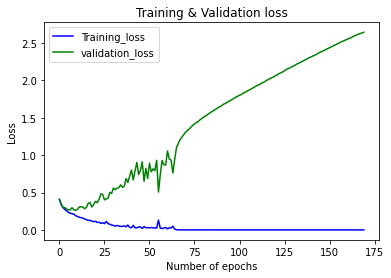

In [24]:
if train_on_gpu:
    model.cuda()
# number of epochs to train the model
n_epochs = 170 #170


valid_loss_min = np.Inf # track change in validation loss

#train_losses,valid_losses=[],[]

train_loss_i = [] 
valid_loss_i = []
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    print('running epoch: {}'.format(epoch))
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in tqdm(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in tqdm(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        
        with torch.no_grad():
            output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    #train_losses.append(train_loss/len(train_loader.dataset))
    #valid_losses.append(valid_loss.item()/len(valid_loader.dataset)
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('\tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        train_loss, valid_loss))
    
    #作圖接收矩陣
    train_loss_i.append(train_loss)
    valid_loss_i.append(valid_loss)

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_CNN.pth')
        valid_loss_min = valid_loss
#作圖區
print(train_loss_i) 
print(valid_loss_i)

plt.plot(range(n_epochs), train_loss_i,'b-', label='Training_loss')
plt.plot(range(n_epochs), valid_loss_i,'g-', label='validation_loss')
plt.title('Training & Validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#TEST MODEL

In [25]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}'.format(test_loss))

    print('Test Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [30]:
use_cuda = torch.cuda.is_available()
model.cuda()
test(test_loader, model, criterion, use_cuda)

AttributeError: can't set attribute

In [28]:
sent_model = model.send(bob)

In [29]:
bob._objects

{38717198139: Parameter containing:
 tensor([[[[ 2.2518e-01,  4.4474e-02,  1.8611e-01],
           [-7.1386e-02, -4.6517e-02,  1.8708e-01],
           [-3.9694e-02, -7.7668e-02, -1.7973e-01]],
 
          [[ 5.5263e-02, -1.1953e-01,  1.3421e-02],
           [ 1.8741e-01, -4.2726e-02,  4.9921e-02],
           [ 6.8323e-02, -1.7339e-02, -2.2771e-01]],
 
          [[ 1.5304e-01,  1.1970e-01,  1.8366e-01],
           [ 1.7631e-01, -7.2917e-02,  1.6216e-01],
           [-9.3266e-02,  1.5026e-02, -1.7069e-01]]],
 
 
         [[[ 1.4097e-01, -4.6749e-02, -1.6216e-02],
           [ 1.5247e-01, -1.8864e-01,  2.0428e-01],
           [-1.7078e-01, -8.0918e-02,  1.3040e-01]],
 
          [[ 4.3684e-02,  1.3602e-01,  2.0695e-01],
           [-2.1768e-01, -2.2349e-01, -7.2285e-02],
           [-2.9923e-01, -1.5102e-01,  4.3255e-02]],
 
          [[ 1.7050e-01, -1.0519e-01,  1.3465e-01],
           [-1.2877e-01,  9.7038e-02, -1.2267e-01],
           [-3.4613e-01, -2.1380e-01,  1.0116e-02]]],
 
 
    